# Parte B: Analítica

In [112]:
import awswrangler as wr
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

El query que usamos para construir la tabal externa `profeco` en la base de datos `profeco_db` es el siguiente

In [4]:
query = '''
    CREATE EXTERNAL TABLE IF NOT EXISTS `profeco_db`.`profeco` (
    `producto` string,
    `marca` string,
    `categoria` string,
    `precio` integer,
    `fechaRegistro` string,
    `giro` string,
    `nombreComercial` string,
    `direccion` string,
    `estado` string,
    `municipio` string,
    `latitud` string,
    `longitud` string
    ) COMMENT "Catalogos de QQP del 18 al 22"
    PARTITIONED BY (`catalogo` string) 
    ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
    WITH SERDEPROPERTIES ('field.delim' = ',')
    STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat' OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
    LOCATION 's3://itam-analytics-abcd/preprocessing/merged/merged_parquet/'
    TBLPROPERTIES ('classification' = 'parquet', "skip.header.line.count"="1");
'''

después ejecutamos el query `MSCK REPAIR TABLE` para datos en formato de estilo Hive: 
El comando MSCK REPAIR TABLE escanea un sistema de archivos, como Amazon S3, en busca de particiones compatibles con Hive. El comando las compara con las particiones que ya están presentes en la tabla y luego agrega las nuevas particiones al catálogo de datos. Ejecuta un comando similar al siguiente:

In [ ]:
query = ''' 
    MSCK REPAIR TABLE profeco_db.profeco

'''

# Analytics

In [ ]:
session = boto3.Session(profile_name='brandon')
s3_client = session.client('s3')

Consumimos la tabla anterior (`profeco_db.profeco`) desde Athena, para reponder: 

## ¿De qué año a qué año tienen datos de esa categoría?

Para responder a esta pregunta, basta con averiguar los distintos años sobre los cuales se tienen registro.

In [16]:
query = '''
    SELECT DISTINCT 
        YEAR(CAST(fecharegistro AS DATE)) AS Anio
    FROM "profeco_db"."profeco"
    WHERE categoria = 'APARATOS ELECTRICOS';
'''

In [18]:
wr.athena.read_sql_query(query, database="profeco_db", 
                         boto3_session=session,
                         ctas_approach=False)

,Anio
0,2018
1,2021
2,2019
3,2022
4,2020


**RESPUESTA**: Hay registros para todos los años, _i.e_ 2018,2019,2020,2021,2022

## ¿Cuántos registros de fecha hay vacíos?

In [45]:
query = '''
    SELECT COUNT(*) AS num_registros_vacios 
    FROM "profeco_db"."profeco" 
    WHERE categoria = 'APARATOS ELECTRICOS' 
    AND (fecharegistro IS NULL OR fecharegistro = '');
'''

In [46]:
wr.athena.read_sql_query(query, database="profeco_db", 
                         boto3_session=session,
                         ctas_approach=False)

,num_registros_vacios
0,0


**RESPUESTA**: Ninguno

## ¿Cuántos registros tienes por año?

In [58]:
query = '''
    SELECT YEAR(CAST(fecharegistro AS DATE)) AS anio, COUNT(*) AS registros_by_anio
    FROM "profeco_db"."profeco" 
    WHERE categoria = 'APARATOS ELECTRICOS' 
    GROUP BY 
        YEAR(CAST(fecharegistro AS DATE))
    ORDER BY anio ASC
'''

In [60]:
registros_anio = wr.athena.read_sql_query(query, database="profeco_db", 
                         boto3_session=session,
                         ctas_approach=False)
print(registros_anio)

   anio  registros_by_anio
0  2018            1054932
1  2019             835971
2  2020             367527
3  2021             630072
4  2022             665678


**RESPUESTA**: 
- En 2018: 1054932 registros
- En 2019: 835971 registros
- En 2020: 367527 registros
- En 2021: 630072 registros
- En 2022: 665678 registros

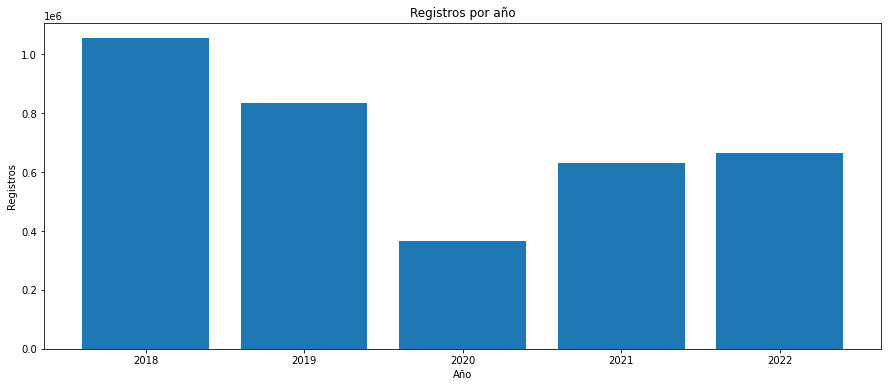

In [69]:
# Datos de la tabla
anio = registros_anio['anio']
registros = registros_anio['registros_by_anio']

# Crear la figura y especificar el tamaño
plt.figure(figsize=(15, 6))

# Crear el gráfico de barras
plt.bar(anio, registros)

# Etiquetas de los ejes
plt.xlabel('Año')
plt.ylabel('Registros')

# Título del gráfico
plt.title('Registros por año')

# Mostrar el gráfico
plt.show()

## ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [93]:
query = '''
    SELECT
        YEAR(CAST(fecharegistro AS DATE)) AS anio,
        MIN(precio) AS minimo,
        MAX(precio) AS maximo,
        AVG(precio) AS media,
        STDDEV(precio) AS sd,
        APPROX_PERCENTILE(precio, 0.25) AS cuartil_1,
        APPROX_PERCENTILE(precio, 0.5) AS mediana,
        APPROX_PERCENTILE(precio, 0.75) AS cuartil_3
    FROM "profeco_db"."profeco" 
    WHERE categoria = 'APARATOS ELECTRICOS' 
    GROUP BY 
        YEAR(CAST(fecharegistro AS DATE))
    ORDER BY anio ASC
'''

In [94]:
basic_stats_by_year = wr.athena.read_sql_query(query, database="profeco_db", 
                         boto3_session=session,
                         ctas_approach=False)

In [95]:
basic_stats_by_year

,anio,minimo,maximo,media,sd,cuartil_1,mediana,cuartil_3
0,2018,115,48999,4879.580198,5274.356725,709,2399,8159
1,2019,114,64999,5003.073061,5424.266405,749,2599,8298
2,2020,119,68499,5279.517165,5641.490974,766,2899,8699
3,2021,138,75899,5959.799675,6151.964051,849,3711,9599
4,2022,62,60719,6640.896222,6760.628183,1039,4299,10690


## Genera un boxplot por año de tu categoría.

In [126]:
five_numbers_resume = basic_stats_by_year.drop(['media','sd'], axis=1)

In [127]:
five_numbers_resume

,anio,minimo,maximo,cuartil_1,mediana,cuartil_3
0,2018,115,48999,709,2399,8159
1,2019,114,64999,749,2599,8298
2,2020,119,68499,766,2899,8699
3,2021,138,75899,849,3711,9599
4,2022,62,60719,1039,4299,10690


In [128]:
five_numbers_resume = pd.melt(five_numbers_resume, id_vars='anio', var_name='estadistica', value_name='precio')

<AxesSubplot:xlabel='anio', ylabel='precio'>

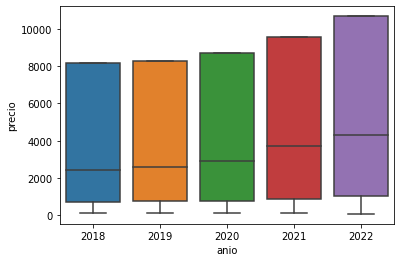

In [122]:
sns.boxplot(x = 'anio', y = 'precio', data = five_numbers_resume, showfliers=False)